在研究中玩转get_price()，很多时候我们在策略里都用的是history的API，但是history暂时不能在notebook中应用，但是其实我们依然可以get_price()拿到我们想要的数据。参考Python文档中的demo我们把例子实现一下。
### 首先介绍一下get_price方法和今天我们要达到的目的：
#### get_price()中的:
   * 1.id_or_symbols 是一个str 或者str list，用于传入需要查询的股票或者股票集或者是基金等。<br/><br/>
   
   * 2.start_date 基本上所有的日期类型都可以，用于传入需要查询的起始日期<br/><br/>
   
   * 3.end_date 与start_date相同，默认是None,是查询的终止日期<br/><br/>
   
   * 4.frequency 是str类型，目前只支持日线和分钟线 （当然，拿到数据我们也可以通过处理得到我们想要的分钟线和月线周线等。<br/><br/>
   
   * 5.fields 是str或者是str list类型 ，用于返回字段，比如说你只要开盘价和收盘价，那么对应的在fields里面只需要填'ClosingPx'和'OpeningPx'
   **详情你可以查看帮助里的PythonAPI里的get_price()中的fields对应的东西！https://www.ricequant.com/api/python/chn#data-methods-get_price**<br/><br/>
   
   * 6.adjust_type 是str类型，复权处理，前复权就是填'pre'，后复权就是'post',不复权用'None'，回测的时候用interval，就是回测用的数据和这个是一致的。<br/><br/>这里顺便科普一下复权处理，就是对股票进行股价和成交量进行权息修复，换句话说，原本你拥有1000股20块的股票，10送10之后就变成了10元，但是，你的股数变成了2000股，对于市值是不改变的。**向前复权，就是保持现在的价格不变，将以前的价格和成交量进行调整。向后复权，就是保持先前的价格不变，而将以后的价格和成交量进行调整。**<br/><br/>**前复权**=(复权前价格-现金红利)÷(1+流通股份变动比例) 可以消除在K线图上的影响，看起来更连贯。<br/><br/>**后复权**==复权前价格×(1+流通股份变动比例)+现金红利<br/><br/>**internal数据**与回测所使用数据保持一致，仅就拆分事件对价格以及成交量进行了前复权处理，并未考虑分红派息对于股价的影响。所以在分红前后，价格会出现跳跃。
     
     
   
   * 7.skip_suspended 是bool类型，是否需要跳过停牌数据，默认是False，但是可以是Ture，不过是能传入一个单个股票或者基金数据。<br/><br/>
   
   * 8.country 是str类型，目前只支持中国股票数据，默认'cn'<br/><br/>
   
### 注：一般情况下，我们在策略里面是不需要管6,7, 8三个选项的。当然现在我们会尝试不同的组合。

#### 我们今天要达到的目的：
    不过在这之前我们先搞清楚我们获得的数据类型是会根据传参而不一样的，这取决于我们传参的造成的维度是多少，
    维度为1则是Series，维度为2就是DataFrame，维度为3就是DataPanel
    比如说目的1里面，我们有股票ID和多个数据（收盘价开盘价等），和时间这两个维度，所以我们就是DataFrame，以此类推。
    但是在目的4里面，我们只有收盘价，股票ID，和时间（就可以优化为使用Series来存储，与list相似）
    在目的7里面我们比起目的1是把股票ID这个维度提高了1（本来是只查一只股票，现在查多了这么多只股票），所以就要变成DataPanel啦
*   1.获取单只股票的历史日线级别的数据（返回的是一个pandas 的DataFrame）<br/><br/>
*   2.获取单只股票的历史日线级别的数据（未经复权的处理，也就是adjust_type这个参数的设置）<br/><br/>
*   3.获取单只股票的历史分钟级别的数据（返回的也是一个pandas的DataFrame）<br/><br/>
*   4.获取单只股票的历史分钟级别的收盘价（返回的是pandas 的Series）<br/><br/>
*   5.获取单一股票历史15分钟线行情（返回pandas DataFrame）<br/><br/>
*   6.获取股票列表历史日线收盘价（返回pandas DataFrame）<br/><br/>
*   7.获取股票列表历史日线行情（返回pandas DataPanel）<br/><br/>

In [30]:
#先开始我们的第一步啦.
import pandas as pd
import numpy as np
a=get_price('000001.XSHE',start_date='2015-04-01',end_date='2015-04-12')
a

,OpeningPx,ClosingPx,HighPx,LowPx,TotalTurnover,TotalVolumeTraded
2015-04-01,10.7300,10.8249,10.9470,10.5469,2.608977e+09,236637563.0
2015-04-02,10.9131,10.7164,10.9470,10.5943,2.222671e+09,202440588.0
2015-04-03,10.6486,10.7503,10.8114,10.5876,2.262844e+09,206631550.0
2015-04-07,10.9538,11.4015,11.5032,10.9538,4.898119e+09,426308008.0
2015-04-08,11.4829,12.1543,12.2628,11.2929,5.784459e+09,485517069.0
2015-04-09,12.1747,12.2086,12.9208,12.0255,5.794632e+09,456921108.0
2015-04-10,12.2086,13.4294,13.4294,12.1069,6.339649e+09,480990210.0


#### 这里我们可以到拿到的是000001.XSHE这只股票的数据，同时我们来查看一下类型

In [11]:
type(a)

pandas.core.frame.DataFrame

#### 这里看到的是一个DataFrame，跟API里描述的一致
#### 然后我们到第二个获取单只股票的日历史级别数据，不复权。

In [12]:
get_price('000001.XSHE',start_date='2015-04-01',end_date='2015-04-12',adjust_type='none')

,OpeningPx,ClosingPx,HighPx,LowPx,TotalTurnover,TotalVolumeTraded
2015-04-01,15.82,15.96,16.14,15.55,2.608977e+09,164331641.0
2015-04-02,16.09,15.80,16.14,15.62,2.222671e+09,140583742.0
2015-04-03,15.70,15.85,15.94,15.61,2.262844e+09,143494132.0
2015-04-07,16.15,16.81,16.96,16.15,4.898119e+09,296047228.0
2015-04-08,16.93,17.92,18.08,16.65,5.784459e+09,337164631.0
2015-04-09,17.95,18.00,19.05,17.73,5.794632e+09,317306325.0
2015-04-10,18.00,19.80,19.80,17.85,6.339649e+09,334020979.0


### 这里我们和上面拿到的数据进行对比一下，就会发现价格不一样，也就是我们是成功做了不复权处理！
### 然后在这里的传输时间我们也可以玩点花的，比如说，我不输入特别的日期，我直接传一个时间到end_date里。
#### 同时提醒一下大家，无论在策略还是研究里，我们都必需传入start_date，但是在策略里我们可以不用传入end_date，默认会传入我们编译策略的时间。*

In [15]:
import datetime  #倒入一个datetime model
get_price('000001.XSHE',start_date='2015-04-01',end_date=datetime.datetime.now())  #datetime.now()是传入现在系统的时间

,OpeningPx,ClosingPx,HighPx,LowPx,TotalTurnover,TotalVolumeTraded
2015-04-01,10.7300,10.8249,10.9470,10.5469,2.608977e+09,236637563.0
2015-04-02,10.9131,10.7164,10.9470,10.5943,2.222671e+09,202440588.0
2015-04-03,10.6486,10.7503,10.8114,10.5876,2.262844e+09,206631550.0
2015-04-07,10.9538,11.4015,11.5032,10.9538,4.898119e+09,426308008.0
2015-04-08,11.4829,12.1543,12.2628,11.2929,5.784459e+09,485517069.0
2015-04-09,12.1747,12.2086,12.9208,12.0255,5.794632e+09,456921108.0
2015-04-10,12.2086,13.4294,13.4294,12.1069,6.339649e+09,480990210.0
2015-04-13,13.9591,13.5813,14.0904,13.2611,8.021097e+09,576858385.0
2015-04-14,13.5485,13.3843,13.5485,13.2201,4.020210e+09,296685001.0
2015-04-15,13.3843,13.6717,14.1890,13.2201,5.746875e+09,410117044.0


#### 实验证明是可以传入自己设置参数的，那么在策略里就可以设定一个context.XX 来存储对于的时间段就不用每次都输日期了，虽然我们建议每次都输入日期，因为这样比较好查错。

### 3.获取单只股票的历史分钟级别的数据，其实就在frequency这个参数上改动一下就好了。

In [8]:
get_price('000001.XSHE', start_date='2015-04-01', end_date='2015-04-12', frequency='1m')

,OpeningPx,ClosingPx,HighPx,LowPx,TotalTurnover,TotalVolumeTraded
2015-04-01 09:31:00,10.7300,10.7164,10.7843,10.6825,84546764.0,7696378.0
2015-04-01 09:32:00,10.7164,10.6893,10.7164,10.6486,26081650.0,2383718.0
2015-04-01 09:33:00,10.6825,10.6825,10.7164,10.6690,15960651.0,1459152.0
2015-04-01 09:34:00,10.6825,10.6893,10.6893,10.6690,16295954.0,1490682.0
2015-04-01 09:35:00,10.6893,10.6961,10.7164,10.6757,20608569.0,1882513.0
2015-04-01 09:36:00,10.7096,10.7232,10.7368,10.6961,15592957.0,1421712.0
2015-04-01 09:37:00,10.7300,10.7503,10.7707,10.7300,16495125.0,1496880.0
2015-04-01 09:38:00,10.7571,10.7029,10.7639,10.7029,22657515.0,2060640.0
2015-04-01 09:39:00,10.7029,10.6893,10.7029,10.6893,25246662.0,2305513.0
2015-04-01 09:40:00,10.6893,10.6893,10.6961,10.6825,23167548.0,2116672.0


#### 分钟级别的数据就是这样了，那么我们其实可以通过数据，来画个小图，比如说15分钟的收盘价的图。

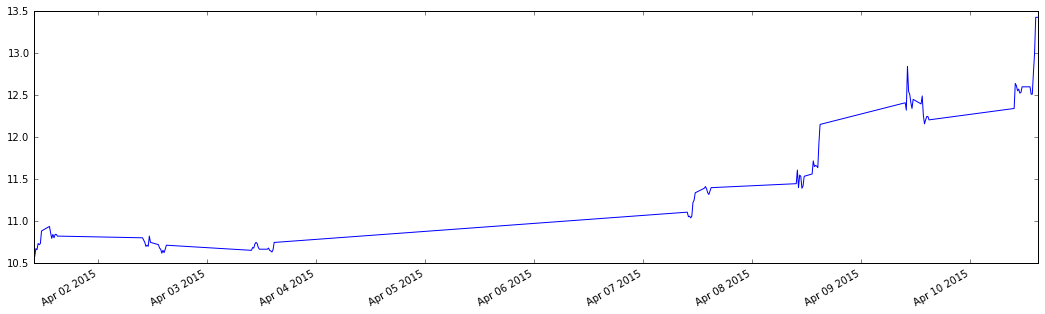

In [14]:
d=get_price('000001.XSHE', start_date='2015-04-01', end_date='2015-04-12',fields='ClosingPx',frequency='15m')
d.plot(x_compat=True,figsize=(18,5))

#### 这里其实运用分钟级别的数据可以去切片我们自己需要的数据，DataFrame的具体操作可以参考10分钟学会Pandas
https://www.ricequant.com/community/topic/1078/

#### 最后我们来获取一下多只股票的数据

In [20]:
stocks=['000024.XSHE', '000001.XSHE', '000002.XSHE']
panel=get_price(stocks,start_date='2015-04-01',end_date='2015-04-12',fields=['ClosingPx','OpeningPx'])
panel

<class 'pandas.core.panel.Panel'>
Dimensions: 2 (items) x 7 (major_axis) x 3 (minor_axis)
Items axis: ClosingPx to OpeningPx
Major_axis axis: 2015-04-01 00:00:00 to 2015-04-10 00:00:00
Minor_axis axis: 000024.XSHE to 000002.XSHE

#### 是的，这里我们又遇到了DataPanel这个复杂的东西，这样显示给我，我什么都看不到啊....那么我们拿到了这个数据要怎么查看我们想要的数据呢？
#### 这里我们看到是有Major_axis:是时间 Minor_axis 是股票 ，而Items则是收盘价和开盘价， df.minor_xs('某股票') df.Major_xs('某时间')都可以帮助我们查看Items

In [23]:
panel.minor_xs('000024.XSHE')

,ClosingPx,OpeningPx
2015-04-01,32.1251,32.6102
2015-04-02,31.6400,32.1251
2015-04-03,31.6400,31.6400
2015-04-07,31.6400,31.6400
2015-04-08,31.6400,31.6400
2015-04-09,31.6400,31.6400
2015-04-10,31.6400,31.6400


#### 如果只想要收盘价的话还可以在后面加上['ClosingPx']

In [24]:
panel.minor_xs('000024.XSHE')['ClosingPx']

2015-04-01    32.1251
2015-04-02    31.6400
2015-04-03    31.6400
2015-04-07    31.6400
2015-04-08    31.6400
2015-04-09    31.6400
2015-04-10    31.6400
Name: ClosingPx, dtype: float64

#### 同理，我们要获取时间为索引的话，那就是panel.major_xs()

In [35]:
panel.major_xs('2015-04-01 00:00:00')

,ClosingPx,OpeningPx
000024.XSHE,32.1251,32.6102
000001.XSHE,10.8249,10.7300
000002.XSHE,12.7398,12.7491


#### 这里注意我们传入时间要把后面的时间也输入进去的，因为存的时候是整个时间作为索引的，如果发现key值不对，那么我们可以直接查看一下整个时间的key值 panel.major_axis

In [38]:
panel.major_axis

DatetimeIndex(['2015-04-01', '2015-04-02', '2015-04-03', '2015-04-07',
               '2015-04-08', '2015-04-09', '2015-04-10'],
              dtype='datetime64[ns]', freq=None)

In [39]:
panel.major_axis[2]

Timestamp('2015-04-03 00:00:00')

#### 这里我们看到传入的是一个Timestamp，所以我们是一定要把时间输全的！！！这个地方我们如果要用到分钟级别的数据就一定会有后面的时间，所以，大家见谅吧~

#### 到这里我们基本就把get_price的基本用法搞清楚了，是时候来一点走心的操作了，那就是我们通过get_fundamentals选取出来股票，然后再传入get_price()获取我们需要的数据。顺便植入一个硬广，那就是我写的另外一个get_fundamentals()的用法啦~https://www.ricequant.com/community/topic/2033/


In [47]:
fundamental_df = get_fundamentals(
        query(
            fundamentals.income_statement.revenue, fundamentals.eod_derivative_indicator.pe_ratio
        ).filter(https://www.ricequant.com/community/topic/2033/
            fundamentals.eod_derivative_indicator.pe_ratio > 55
        ).filter(
            fundamentals.eod_derivative_indicator.pe_ratio < 60
        ).order_by(
            fundamentals.income_statement.revenue.desc()
        ).limit(
            10
        ),entry_date='2016-04-01',interval='5y'  #策略里填写如果只需要股票池，那么entry_date和interval是不需要填写的，但是notebook中是要的
    )

stocks = np.array(fundamental_df.minor_axis)
stocks

array(['600704.XSHG', '601808.XSHG', '601727.XSHG', '600998.XSHG',
       '600875.XSHG', '000626.XSHE', '601866.XSHG', '600297.XSHG',
       '600011.XSHG'], dtype=object)

In [48]:
get_price(stocks,start_date='2015-05-02',end_date='2015-05-12')

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

#### 这里看到我们是不能用Array来传入我们想要查的股票，因为传入的类型只能是str list或者str~

In [49]:
https://www.ricequant.com/research/user/user_355001/notebooks/%E8%A1%8C%E6%83%85%E6%95%B0%E6%8D%AE%E6%9F%A5%E8%AF%A2%E7%A4%BA%E4%BE%8B.ipynb#%E8%BF%99%E9%87%8C%E7%9C%8B%E5%88%B0%E6%88%91%E4%BB%AC%E6%98%AF%E4%B8%8D%E8%83%BD%E7%94%A8Array%E6%9D%A5%E4%BC%A0%E5%85%A5%E6%88%91%E4%BB%AC%E6%83%B3%E8%A6%81%E6%9F%A5%E7%9A%84%E8%82%A1%E7%A5%A8%EF%BC%8C%E5%9B%A0%E4%B8%BA%E4%BC%A0%E5%85%A5%E7%9A%84%E7%B1%BB%E5%9E%8B%E5%8F%AA%E8%83%BD%E6%98%AFstr-list%E6%88%96%E8%80%85str~stocks2 = list(fundamental_df.minor_axis)
stocks2

['600704.XSHG',
 '601808.XSHG',
 '601727.XSHG',
 '600998.XSHG',
 '600875.XSHG',
 '000626.XSHE',
 '601866.XSHG',
 '600297.XSHG',
 '600011.XSHG']

In [50]:
get_price(stocks2,start_date='2015-05-02',end_date='2015-05-12')

<class 'pandas.core.panel.Panel'>
Dimensions: 6 (items) x 7 (major_axis) x 9 (minor_axis)
Items axis: OpeningPx to TotalVolumeTraded
Major_axis axis: 2015-05-04 00:00:00 to 2015-05-12 00:00:00
Minor_axis axis: 600704.XSHG to 600011.XSHG

#### 至此，我们基本已经把get_price()整个方法过了一遍，普通运用是没有什么问题的啦，不过想要玩更花的，比如说根据这个收盘数据去动态选股，每天更新股票这种操作，大家就先可以探索了，在有生之年，我会更新出来的，哈哈哈哈~谢谢大家